In [315]:
# Importing necessary models
import warnings
warnings.filterwarnings('ignore')

import smtplib
import pandas as pd
import numpy as np
import datetime as dt
import pandas.stats.moments as st
import time
%matplotlib inline
from bs4 import BeautifulSoup as bs
import requests
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sqlalchemy import *
from sqlalchemy import create_engine
import calendar
import sqlite3 as sql
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.4f}'.format
from scipy.stats import norm as norm
init_notebook_mode(connected=True)

import os

dbs_dir = 'D:\Options Data\SPX'

os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Trading\\Modules\\DataCollection')

from yahoo_query import *

os.chdir('D:\Price Data\SPX and VIX Intraday TWS')

ib_index_engine = create_engine('sqlite:///ib_index_intraday.db', echo = False)

os.chdir(dbs_dir)

query = "SELECT date, open_spx, high_spx, low_spx, close_spx, open_vix, high_vix, low_vix, close_vix FROM indexIntraday"

index_intraday = pd.read_sql_query(query, con = ib_index_engine, index_col = 'date')
index_intraday.index = pd.to_datetime(index_intraday.index)
index_intraday = index_intraday.sort_index()
index_intraday['date_day'] = index_intraday.index.date
index_intraday['EOD'] = (index_intraday['date_day'].shift(-1) - index_intraday['date_day']).dt.days
index_intraday['BOD'] = (index_intraday['date_day'].shift(1) - index_intraday['date_day']).dt.days
index_intraday = index_intraday.fillna(1)

In [12]:
# Retrieving Data for VIX Term Structure
v1 = pd.read_csv('https://www.quandl.com/api/v3/datasets/CHRIS/CBOE_VX1.csv?api_key=dzmzEExntfap7SNx5p6t', index_col = 0)[['Open','Close']].sort_index()
v2 = pd.read_csv('https://www.quandl.com/api/v3/datasets/CHRIS/CBOE_VX2.csv?api_key=dzmzEExntfap7SNx5p6t', index_col = 0)[['Open','Close']].sort_index()
vix = pd.read_csv('http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/vixcurrent.csv', skiprows=[0], index_col = 0)
vix.index = pd.to_datetime(vix.index)
vix_term = vix.join(v1.join(v2, lsuffix = '_F1', rsuffix = '_F2').dropna()).dropna()

spx = yahoo_query('^GSPC', dt.datetime(2018,7,30))
spx.hist_prices_query()
spx = spx.hist_prices
index_df = spx[['^GSPC_open','^GSPC_adjclose']].join(vix_term)
index_df.columns = [x.replace('^GSPC','SPX') for x in index_df.columns.tolist()]

In [319]:
options_files = sorted(os.listdir())


daylights_savings = dt.datetime(2018,11,4)

period_window = 60
commissions = 0.0266
number_of_contracts = 6

eod_options = list(set([dt.datetime.strptime(x.split('.csv')[0][:-6].replace('spx_',''), '%Y-%m-%d') for x in options_files]))
eod_options = [x.strftime('%Y-%m-%d') for x in sorted(eod_options)]

eod_files = []
for eod_option in eod_options:
    all_eod_files = sorted(list(filter(lambda x: eod_option in x, options_files)))
    try:
        eod_file = sorted(list(filter(lambda x: x[-9:-7] == '13', all_eod_files)))[0]
        eod_files.append(eod_file)
    except:
        continue
    
eod_options = eod_files

eod_options_df = []

for options_file in eod_options:
    next_chains = pd.read_csv(options_file, index_col = 0)[['Strike','Expiry','Type',
                                                       'Symbol','Bid','Ask','Vol','Open_Int',
                                                       'IV','Underlying_Price','Quote_Time']]
    next_chains.Quote_Time = pd.to_datetime(next_chains.Quote_Time).map(lambda x: x.replace(second=0))
    
    if next_chains.Quote_Time[0] < daylights_savings:
        next_chains.Quote_Time = next_chains.Quote_Time - dt.timedelta(seconds = 60*60*7)
    else:
        next_chains.Quote_Time = next_chains.Quote_Time - dt.timedelta(seconds = 60*60*8)
        
    next_chains.Expiry = pd.to_datetime(next_chains.Expiry)
    next_chains['DTE'] = (next_chains.Expiry - next_chains.Quote_Time).dt.days + 1
    eod_options_df.append(next_chains)
    
eod_options_df = pd.concat(eod_options_df, axis = 0).reset_index(drop = True)
eod_options_df['date'] = eod_options_df.Quote_Time.dt.date

existing_options = eod_options_df[eod_options_df.Symbol.isin(eod_options_df[eod_options_df.DTE == 0].Symbol.drop_duplicates())].reset_index(drop = True)

In [289]:
approx_delta = 0.3

long_puts = pd.DataFrame(columns = curr_chain.columns.tolist())
short_puts = pd.DataFrame(columns = curr_chain.columns.tolist())

long_calls = pd.DataFrame(columns = curr_chain.columns.tolist())
short_calls = pd.DataFrame(columns = curr_chain.columns.tolist())

for idx, day in index_df.iterrows():
    curr_chain = existing_options[existing_options.date == idx.date()]
    
    if len(curr_chain) == 0 or idx.date() == dt.date(2019,3,4):
        continue
    
    if curr_chain.DTE.drop_duplicates().sort_values().tolist()[1] > 2:
        continue
        
    curr_spx_close = day.SPX_adjclose
    curr_iv_1day = day['VIX Close']/(100*np.sqrt(365.25))

    curr_lower_strike = curr_spx_close*np.exp(norm.ppf(approx_delta, 0, curr_iv_1day))
    curr_upper_strike = curr_spx_close*np.exp(norm.ppf(1 - approx_delta, 0, curr_iv_1day))
    
    curr_puts = curr_chain[(curr_chain.Type == 'put') &
                           (curr_chain.Strike <= curr_lower_strike) &
                           (curr_chain.DTE == curr_chain.DTE.drop_duplicates().sort_values().tolist()[1])].sort_values(['Strike'], 
                                                                                                                       ascending = False).head(2).reset_index(drop = True)
    curr_calls = curr_chain[(curr_chain.Type == 'call') &
                            (curr_chain.Strike >= curr_upper_strike) &
                            (curr_chain.DTE == curr_chain.DTE.drop_duplicates().sort_values().tolist()[1])].sort_values(['Strike']).head(2).reset_index(drop = True)
    
    if day['VIX Close'] < day['Close_F1'] and curr_puts.loc[0,'Symbol'] not in short_puts.Symbol.tolist() and curr_puts.loc[1,'Symbol'] not in long_puts.Symbol.tolist():
        if abs(curr_puts.Strike.diff()).loc[1] == 5:
        
            short_puts = short_puts.append(curr_puts.iloc[0])
            long_puts = long_puts.append(curr_puts.iloc[1])
    
    if day['VIX Close'] >= day['Close_F1'] and curr_calls.loc[0,'Symbol'] not in short_calls.Symbol.tolist() and curr_calls.loc[1,'Symbol'] not in long_calls.Symbol.tolist():
        if abs(curr_calls.Strike.diff()).loc[1] == 5:
        
            short_calls = short_calls.append(curr_calls.iloc[0])
            long_calls = long_calls.append(curr_calls.iloc[1])
        
long_puts = long_puts[['Strike','Expiry','Symbol','Bid','Ask','Underlying_Price','DTE','date']].set_index('Symbol')
short_puts = short_puts[['Strike','Expiry','Symbol','Bid','Ask','Underlying_Price','DTE','date']].set_index('Symbol')
long_calls = long_calls[['Strike','Expiry','Symbol','Bid','Ask','Underlying_Price','DTE','date']].set_index('Symbol')
short_calls = short_calls[['Strike','Expiry','Symbol','Bid','Ask','Underlying_Price','DTE','date']].set_index('Symbol')

short_put_perf = short_puts.join(existing_options[existing_options.DTE == 0].set_index('Symbol')[['Underlying_Price','date']],
                                 lsuffix = '_entry', rsuffix = '_ending').set_index('date_ending')

long_put_perf = long_puts.join(existing_options[existing_options.DTE == 0].set_index('Symbol')[['Underlying_Price','date']],
                                 lsuffix = '_entry', rsuffix = '_ending').set_index('date_ending')

short_call_perf = short_calls.join(existing_options[existing_options.DTE == 0].set_index('Symbol')[['Underlying_Price','date']],
                                 lsuffix = '_entry', rsuffix = '_ending').set_index('date_ending')

long_call_perf = long_calls.join(existing_options[existing_options.DTE == 0].set_index('Symbol')[['Underlying_Price','date']],
                                 lsuffix = '_entry', rsuffix = '_ending').set_index('date_ending')

short_put_perf['PnL'] = (short_put_perf.Underlying_Price_ending < short_put_perf.Strike)*(short_put_perf.Underlying_Price_ending - short_put_perf.Strike)
short_put_perf['PnL'] = short_put_perf['PnL'] + round((short_put_perf['Bid'] + short_put_perf['Ask'] - 0.0266)/2,2)

long_put_perf['PnL'] = (long_put_perf.Underlying_Price_ending < long_put_perf.Strike)*(long_put_perf.Strike - long_put_perf.Underlying_Price_ending)
long_put_perf['PnL'] = long_put_perf['PnL'] - round((long_put_perf['Bid'] + long_put_perf['Ask'] - 0.0266)/2,2)

short_call_perf['PnL'] = (short_call_perf.Underlying_Price_ending > short_call_perf.Strike)*(short_call_perf.Underlying_Price_ending - short_call_perf.Strike)
short_call_perf['PnL'] = short_call_perf['PnL'] + round((short_call_perf['Bid'] + short_call_perf['Ask'] - 0.0266)/2,2)

long_call_perf['PnL'] = (long_call_perf.Underlying_Price_ending > long_call_perf.Strike)*(long_call_perf.Strike - long_call_perf.Underlying_Price_ending)
long_call_perf['PnL'] = long_call_perf['PnL'] - round((long_call_perf['Bid'] + long_call_perf['Ask'] - 0.0266)/2,2)

ps = short_put_perf.reset_index()[['date_ending','PnL']].groupby('date_ending').sum().join(long_put_perf.reset_index()[['date_ending','PnL']].groupby('date_ending').sum(), lsuffix = '_short', rsuffix = '_long')
ps['Total_PS_PnL'] = ps.PnL_short + ps.PnL_long

cs = short_call_perf.reset_index()[['date_ending','PnL']].groupby('date_ending').sum().join(long_call_perf.reset_index()[['date_ending','PnL']].groupby('date_ending').sum(), lsuffix = '_short', rsuffix = '_long')
cs['Total_CS_PnL'] = cs.PnL_short + cs.PnL_long

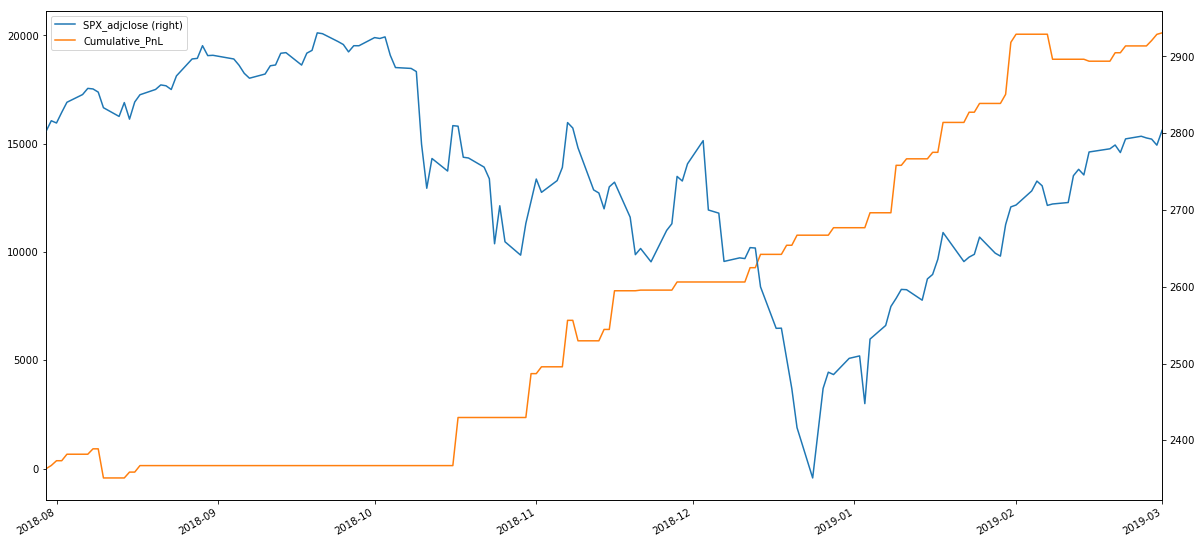

In [297]:
contracts = 3

backtest_df = index_df[['SPX_adjclose','VIX Close','Close_F1']].dropna().join(ps['Total_PS_PnL']).join(cs['Total_CS_PnL'])

backtest_df = backtest_df.join(short_put_perf.set_index('date_entry')[['Strike','DTE']]).join(long_put_perf.set_index('date_entry')[['Strike','DTE']],
                                                                                lsuffix = '_short_put', rsuffix = '_long_put')
backtest_df = backtest_df.join(short_call_perf.set_index('date_entry')[['Strike','DTE']]).join(long_call_perf.set_index('date_entry')[['Strike','DTE']],
                                                                                lsuffix = '_short_call', rsuffix = '_long_call')
backtest_df = backtest_df.fillna(0)
backtest_df['Total_PnL'] = (backtest_df.Total_PS_PnL + backtest_df.Total_CS_PnL)*contracts*100
backtest_df['Cumulative_PnL'] = backtest_df.Total_PnL.expanding(1).sum()
backtest_df[['SPX_adjclose','Cumulative_PnL']].plot(figsize = (20,10),
                                                    secondary_y = 'SPX_adjclose')

# Testing 0 DTE

In [320]:
bod_options = list(set([dt.datetime.strptime(x.split('.csv')[0][:-6].replace('spx_',''), '%Y-%m-%d') for x in options_files]))
bod_options = [x.strftime('%Y-%m-%d') for x in sorted(bod_options)]

bod_files = []
for bod_option in bod_options:
    all_bod_files = sorted(list(filter(lambda x: bod_option in x, options_files)))
    try:
        bod_file = sorted(list(filter(lambda x: x[-9:-7] == '06', all_bod_files)))[1]
        bod_files.append(bod_file)
    except:
        continue
    
bod_options = bod_files

bod_options_df = []

for options_file in bod_options:
    next_chains = pd.read_csv(options_file, index_col = 0)[['Strike','Expiry','Type',
                                                       'Symbol','Bid','Ask','Vol','Open_Int',
                                                       'IV','Underlying_Price','Quote_Time']]
    next_chains.Quote_Time = pd.to_datetime(next_chains.Quote_Time).map(lambda x: x.replace(second=0))
    
    if next_chains.Quote_Time[0] < daylights_savings:
        next_chains.Quote_Time = next_chains.Quote_Time - dt.timedelta(seconds = 60*60*7)
    else:
        next_chains.Quote_Time = next_chains.Quote_Time - dt.timedelta(seconds = 60*60*8)

    next_chains.Expiry = pd.to_datetime(next_chains.Expiry)
    next_chains['DTE'] = (next_chains.Expiry - next_chains.Quote_Time).dt.days + 1
    bod_options_df.append(next_chains)
    
bod_options_df = pd.concat(bod_options_df, axis = 0).reset_index(drop = True)
bod_options_df['date'] = bod_options_df.Quote_Time.dt.date
existing_options_bod = bod_options_df[bod_options_df.Symbol.isin(bod_options_df[bod_options_df.DTE == 0].Symbol.drop_duplicates())].reset_index(drop = True)
bod_0dte = existing_options_bod[existing_options_bod.DTE == 0]
eod_0dte = existing_options[existing_options.DTE == 0]

options_0dte = bod_0dte.merge(eod_0dte, how = 'inner', on = 'Symbol', suffixes = ('_bod','_eod')).sort_values(['date_bod','Type_bod','Strike_bod']).reset_index(drop = True)

In [511]:
put_spreads_0dte = []
call_spreads_0dte = []

for date_0dte in options_0dte.Quote_Time_bod.drop_duplicates():
    
    curr_0dte_index = index_intraday[index_intraday.index == date_0dte]
    
    open_f1 = index_df[index_df.index.date == date_0dte.date()].reset_index().loc[0,'Open_F1']
    open_vix = index_df[index_df.index.date == date_0dte.date()].reset_index().loc[0,'VIX Open']
    
    if len(curr_0dte_index) == 0:
        continue
        
    curr_iv_1day = curr_0dte_index.reset_index().loc[0,'close_vix']/(100*np.sqrt(365.25))

    curr_lower_strike = curr_0dte_index.reset_index().loc[0,'close_spx']*np.exp(norm.ppf(approx_delta, 0, curr_iv_1day))
    curr_upper_strike = curr_0dte_index.reset_index().loc[0,'close_spx']*np.exp(norm.ppf(1 - approx_delta, 0, curr_iv_1day))
    
    curr_chain = options_0dte[options_0dte.Quote_Time_bod == date_0dte]
    curr_puts = curr_chain[(curr_chain.Strike_bod < curr_lower_strike) &
                           (curr_chain.Type_bod == 'put')].sort_values('Strike_bod', ascending = False).head(2).reset_index(drop = True)
    curr_puts = curr_puts[['date_bod','Strike_bod','Expiry_bod','Bid_bod','Ask_bod','Bid_eod','Ask_eod','Underlying_Price_bod','Underlying_Price_eod']]
    curr_puts['Mid'] = (curr_puts['Bid_bod'] + curr_puts['Ask_bod'])/2
    
    curr_calls = curr_chain[(curr_chain.Strike_bod > curr_upper_strike) &
                       (curr_chain.Type_bod == 'call')].sort_values('Strike_bod').head(2).reset_index(drop = True)
    curr_calls = curr_calls[['date_bod','Strike_bod','Expiry_bod','Bid_bod','Ask_bod','Bid_eod','Ask_eod','Underlying_Price_bod','Underlying_Price_eod']]
    curr_calls['Mid'] = (curr_calls['Bid_bod'] + curr_calls['Ask_bod'])/2
    
    if open_vix < open_f1 and abs(curr_puts.Strike_bod.diff()).loc[1] == 5:
        curr_ps = pd.DataFrame(index = [0])
        curr_ps['date'] = curr_puts.loc[0,'date_bod']
        curr_ps['Strike_short'] = curr_puts.loc[0,'Strike_bod']
        curr_ps['Strike_long'] = curr_puts.loc[1,'Strike_bod']
        curr_ps['Credit'] = curr_puts.loc[0,'Mid'] - curr_puts.loc[1,'Mid'] - 0.0266
        curr_ps['SPX_bod'] = curr_puts.loc[0, 'Underlying_Price_bod']
        curr_ps['SPX_eod'] = curr_puts.loc[0, 'Underlying_Price_eod']
        
        if curr_ps.loc[0,'Strike_short'] > curr_ps.loc[0,'SPX_eod']:
            if curr_ps.loc[0,'Strike_long'] > curr_ps.loc[0,'SPX_eod']:
                curr_ps['PnL'] = curr_ps.Credit - 5
            else:
                curr_ps['PnL'] = (curr_ps['SPX_eod'] - curr_ps['Strike_long'] - 5) + curr_ps.Credit
                
        else:
            curr_ps['PnL'] = curr_ps.Credit
            
        put_spreads_0dte.append(curr_ps)
        
    if open_vix >= open_f1 and abs(curr_puts.Strike_bod.diff()).loc[1] == 5:
        curr_cs = pd.DataFrame(index = [0])
        curr_cs['date'] = curr_calls.loc[0,'date_bod']
        curr_cs['Strike_short'] = curr_calls.loc[0,'Strike_bod']
        curr_cs['Strike_long'] = curr_calls.loc[1,'Strike_bod']
        curr_cs['Credit'] = curr_calls.loc[0,'Mid'] - curr_calls.loc[1,'Mid'] - 0.0266
        curr_cs['SPX_bod'] = curr_calls.loc[0, 'Underlying_Price_bod']
        curr_cs['SPX_eod'] = curr_calls.loc[0, 'Underlying_Price_eod']
        
        if curr_cs.loc[0,'Strike_short'] < curr_cs.loc[0,'SPX_eod']:
            if curr_cs.loc[0,'Strike_long'] < curr_cs.loc[0,'SPX_eod']:
                curr_cs['PnL'] = curr_cs.Credit - 5
            else:
                curr_cs['PnL'] = (curr_cs['Strike_long'] - curr_cs['SPX_eod'] - 5) + curr_cs.Credit
        else:
            curr_cs['PnL'] = curr_cs.Credit
                
        call_spreads_0dte.append(curr_cs)


In [509]:
condor_0dte = pd.concat(put_spreads_0dte, axis = 0).set_index('date').join(pd.concat(call_spreads_0dte, axis = 0).set_index('date'),
                                                            lsuffix = '_ps', rsuffix = '_cs')


In [510]:
condor_0dte['Total_PnL'] = (condor_0dte['PnL_ps'] + condor_0dte['PnL_cs'])*contracts*100
condor_0dte_backtest = index_df[['SPX_adjclose','VIX Close','Close_F1']].dropna().join(condor_0dte['Total_PnL']).fillna(0)
condor_0dte_backtest['Cumulative PnL'] = condor_0dte_backtest.Total_PnL.expanding(1).sum()
condor_0dte_backtest



,SPX_adjclose,VIX Close,Close_F1,Total_PnL,Cumulative PnL
2018-07-30,"2,802.6001",14.2600,14.8500,-141.9600,-141.9600
2018-07-31,"2,816.2900",12.8300,14.0500,749.0400,607.0800
2018-08-01,"2,813.3601",13.1500,14.2000,261.5400,868.6200
2018-08-02,"2,827.2200",12.1900,13.8500,0.0000,868.6200
2018-08-03,"2,840.3501",11.6400,13.5600,260.0400,"1,128.6600"
2018-08-06,"2,850.3999",11.2700,13.1000,-42.9600,"1,085.7000"
2018-08-07,"2,858.4500",10.9300,12.7000,0.0000,"1,085.7000"
2018-08-08,"2,857.7000",10.8500,12.6100,261.5400,"1,347.2400"
2018-08-09,"2,853.5801",11.2700,12.7000,0.0000,"1,347.2400"
2018-08-10,"2,833.2800",13.1600,13.5700,419.0400,"1,766.2800"


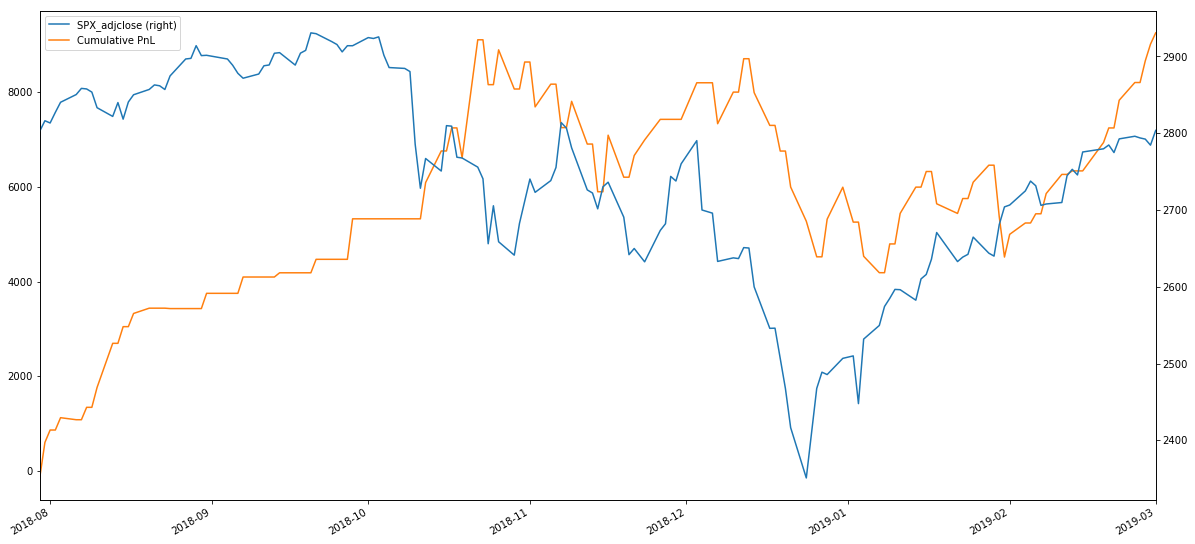

In [518]:
condor_0dte_backtest[['SPX_adjclose','Cumulative PnL']].plot(figsize = (20,10),
                                                    secondary_y = 'SPX_adjclose')

In [512]:
term_0dte_strat = pd.concat(put_spreads_0dte + call_spreads_0dte, axis = 0).sort_values('date').set_index('date')

In [513]:

term_0dte_strat['Total_PnL'] = term_0dte_strat['PnL']*contracts*100

term_0dte_strat_backtest = index_df[['SPX_adjclose','VIX Close','Close_F1']].dropna().join(term_0dte_strat['Total_PnL']).fillna(0)
term_0dte_strat_backtest['Cumulative PnL'] = term_0dte_strat_backtest.Total_PnL.expanding(1).sum()


term_0dte_strat_backtest

,SPX_adjclose,VIX Close,Close_F1,Total_PnL,Cumulative PnL
2018-07-30,"2,802.6001",14.2600,14.8500,-546.4800,-546.4800
2018-07-31,"2,816.2900",12.8300,14.0500,0.0000,-546.4800
2018-08-01,"2,813.3601",13.1500,14.2000,179.5200,-366.9600
2018-08-02,"2,827.2200",12.1900,13.8500,0.0000,-366.9600
2018-08-03,"2,840.3501",11.6400,13.5600,157.0200,-209.9400
2018-08-06,"2,850.3999",11.2700,13.1000,52.0200,-157.9200
2018-08-07,"2,858.4500",10.9300,12.7000,0.0000,-157.9200
2018-08-08,"2,857.7000",10.8500,12.6100,52.0200,-105.9000
2018-08-09,"2,853.5801",11.2700,12.7000,0.0000,-105.9000
2018-08-10,"2,833.2800",13.1600,13.5700,164.5200,58.6200


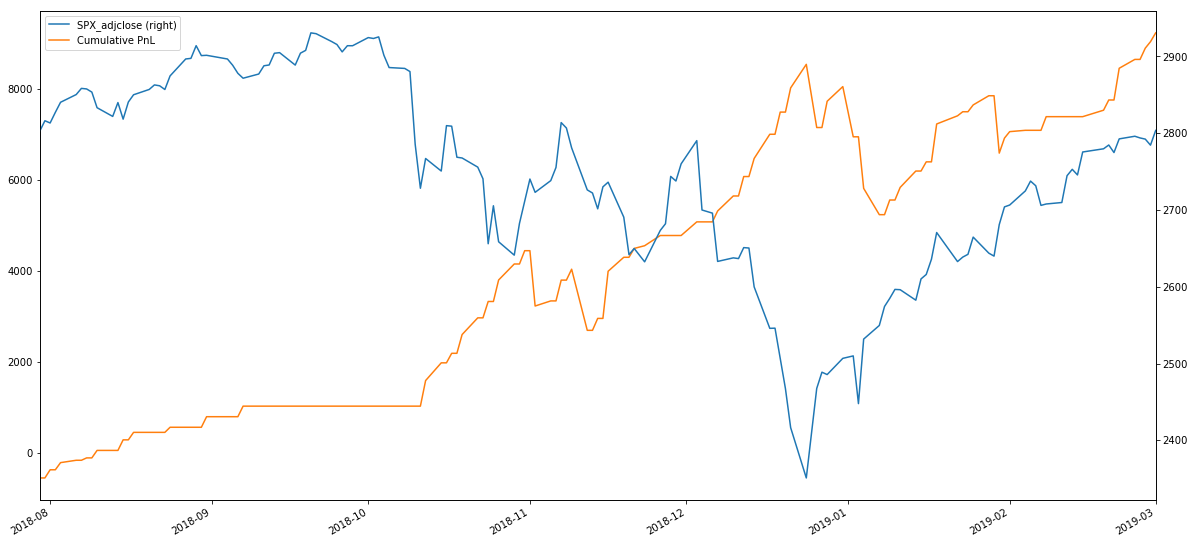

In [516]:
term_0dte_strat_backtest[['SPX_adjclose','Cumulative PnL']].plot(figsize = (20,10),
                                                    secondary_y = 'SPX_adjclose')

In [519]:
term_0dte_strat_backtest.describe()

,SPX_adjclose,VIX Close,Close_F1,Total_PnL,Cumulative PnL
count,148.0000,148.0000,148.0000,148.0000,148.0000
mean,"2,746.0200",17.5770,17.5598,62.3874,"3,902.7316"
std,127.5641,4.8201,3.3240,338.1555,"2,937.2279"
min,"2,351.1001",10.8500,12.6100,"-1,387.9800",-546.4800
25%,"2,654.8426",13.4150,14.3000,0.0000,"1,031.2200"
50%,"2,754.2400",16.6450,17.1150,0.0000,"4,017.5100"
75%,"2,856.9975",20.6650,19.9425,213.2700,"6,963.3450"
max,"2,930.7500",36.0700,25.9500,"1,036.0200","9,233.3400"


In [520]:
term_0dte_strat_backtest

,SPX_adjclose,VIX Close,Close_F1,Total_PnL,Cumulative PnL
2018-07-30,"2,802.6001",14.2600,14.8500,-546.4800,-546.4800
2018-07-31,"2,816.2900",12.8300,14.0500,0.0000,-546.4800
2018-08-01,"2,813.3601",13.1500,14.2000,179.5200,-366.9600
2018-08-02,"2,827.2200",12.1900,13.8500,0.0000,-366.9600
2018-08-03,"2,840.3501",11.6400,13.5600,157.0200,-209.9400
2018-08-06,"2,850.3999",11.2700,13.1000,52.0200,-157.9200
2018-08-07,"2,858.4500",10.9300,12.7000,0.0000,-157.9200
2018-08-08,"2,857.7000",10.8500,12.6100,52.0200,-105.9000
2018-08-09,"2,853.5801",11.2700,12.7000,0.0000,-105.9000
2018-08-10,"2,833.2800",13.1600,13.5700,164.5200,58.6200


In [523]:
pd.concat(put_spreads_0dte,axis = 0)

,date,Strike_short,Strike_long,Credit,SPX_bod,SPX_eod,PnL
0,2018-07-30,"2,805.0000","2,800.0000",0.6984,"2,816.2500","2,802.4800",-1.8216
0,2018-08-01,"2,810.0000","2,805.0000",0.5984,"2,822.3500","2,813.6300",0.5984
0,2018-08-03,"2,820.0000","2,815.0000",0.5234,"2,829.5900","2,840.2300",0.5234
0,2018-08-06,"2,825.0000","2,820.0000",0.1734,"2,836.6400","2,850.5400",0.1734
0,2018-08-08,"2,840.0000","2,835.0000",0.1734,"2,855.7900","2,857.7700",0.1734
0,2018-08-10,"2,825.0000","2,820.0000",0.5484,"2,838.5500","2,833.1800",0.5484
0,2018-08-15,"2,810.0000","2,805.0000",0.7734,"2,821.9400","2,818.4900",0.7734
0,2018-08-17,"2,825.0000","2,820.0000",0.5484,"2,837.3400","2,850.1200",0.5484
0,2018-08-24,"2,855.0000","2,850.0000",0.3734,"2,864.6200","2,874.8300",0.3734
0,2018-08-31,"2,885.0000","2,880.0000",0.7734,"2,897.8900","2,901.1200",0.7734


In [529]:
pd.concat(put_spreads_0dte + call_spreads_0dte,axis = 0).set_index('date').sort_index().to_csv('dte0.csv')